In [31]:
import datetime
import glob
import logging
import os
import re

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import qgrid
from IPython.display import display, HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


def setup_logger(name):
    logger = logging.getLogger(name)
    FORMAT = '%(asctime)s,%(msecs)d %(levelname)-8s [%(filename)s:%(lineno)d] %(message)s'
    formatter = logging.Formatter(fmt=FORMAT)
    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    logger.handlers = []
    logger.addHandler(handler)
    logger.propagate = False
    return logger

logger = setup_logger(__name__)
logger.setLevel(logging.INFO)

In [32]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

In [33]:
TIME_FORMAT = "%Y-%m-%d_%H-%M"

DATA_COLUMNS_RENAME_DICT = {
    "LP": "liste_permanente", "LS": "liste_suplimentare", "UM": "urna_mobila" , "LT": "total"}
INDEX_COLUMNS_RENAME_DICT = {"Nume sectie de votare": "Sectie",
                             "Nr sectie de votare": "Nr Sectie",
                             "Votanti lista": "lista"}
DATA_COLUMNS = list(DATA_COLUMNS_RENAME_DICT.values())
INDEX_COLUMNS = ["Judet","UAT", "Localitate", "Siruta", "Nr Sectie", "Sectie", "Mediu", "lista"]
REDUCED_INDEX_COLUMNS = ["Judet", "Localitate", "Nr Sectie", "lista", "total", "time"]
ORIGINAL_COLUMNS = INDEX_COLUMNS + DATA_COLUMNS
FINAL_COLUMNS_RENAME_DICT = {"total": "votanti_final",
                             "liste_suplimentare": "liste_suplimentare_final",
                             "liste_permanente": "liste_permanente_final",
                             "urna_mobila": "urna_mobila_final"}
FINAL_COLUMNS = ["total", "lista"] + list(FINAL_COLUMNS_RENAME_DICT.values())

INTERVALS_XLABELS = ['6 Oct, 7:00\n6 Oct, 10:00',
                     '6 Oct, 10:00\n6 Oct, 13:00', '6 Oct, 13:00\n6 Oct, 16:00', '6 Oct, 16:00\n6 Oct, 19:00',
                     '6 Oct, 19:00\n6 Oct, 21:00', '7 Oct, 7:00\n7 Oct, 10:00', '7 Oct, 10:00\n7 Oct, 13:00',
                     '7 Oct, 13:00\n7 Oct, 16:00', '7 Oct, 16:00\n7 Oct, 19:00', '7 Oct, 19:00\n7 Oct, 21:00']
TIME_XLABELS = ["Pana la {}".format(i.split("\n")[1]) for i in INTERVALS_XLABELS]

def build_xlabels(df):
    times = ["2018-10-06_7-00"] + sorted(df.time.unique())
    times = [datetime.datetime.strptime(date_str, TIME_FORMAT) for date_str in times]
    times = ["{} Oct, {}:00".format(d.day, d.hour) for d in times]
    xes = ["\n".join(i) for i in list(zip(times, times[1:]))]

def get_hour_difference(date1_str, date2_str):
    d1 = datetime.datetime.strptime(date1_str, TIME_FORMAT)
    d2 = datetime.datetime.strptime(date2_str, TIME_FORMAT)
    return (d1.day - d2.day) * 14 + (d1.hour - d2.hour)

JUDETE_DICT = {
    'B': "Bucuresti",
    'AB': 'Alba',
    'AG': 'Arges',
    'AR': 'Arad',
    'BC': 'Bacau',
    'BH': 'Bihor',
    'BN': 'Bistrita Nasaud',
    'BT': 'Botosani',
    'BR': 'Braila',
    'BV': 'Brasov',
    'BZ': 'Buzau',
    'CL': 'Calarasi',
    'CS': 'Caras Severin',
    'CJ': 'Cluj',
    'CT': 'Constanta',
    'CV': 'Covasna',
    'DB': 'Dambovita',
    'DJ': 'Dolj',
    'GL': 'Galati',
    'GR': 'Giurgiu',
    'GJ': 'Gorj',
    'HR': 'Harghita',
    'HD': 'Hunedoara',
    'IL': 'Ialomita',
    'IS': 'Iasi',
    'IF': 'Ilfov',
    'MM': 'Maramures',
    'MH': 'Mehedinti',
    'MS': 'Mures',
    'NT': 'Neamt',
    'OT': 'Olt',
    'PH': 'Prahova',
    'SJ': 'Salaj',
    'SM': 'Satu Mare',
    'SB': 'Sibiu',
    'SV': 'Suceava',
    'TR': 'Teleorman',
    'TM': 'Timis',
    'TL': 'Tulcea',
    'VL': 'Valcea',
    'VS': 'Vaslui',
    'VN': 'Vrancea'}

In [34]:
total_presence_df = pd.read_csv("../data/simple_all_data.csv")
total_presence_df.loc[:, "Mediu"] = total_presence_df["Mediu"].map({"R": "Rural", "U": "Urban"})
final_df = total_presence_df[total_presence_df["time"] == total_presence_df["time"].max()]

## Helper functions

In [35]:
def judete_diff_max_mediu(final_df, new_column, numerator_column, denominator_column):
    columns = ["liste_permanente", "liste_suplimentare", "urna_mobila", "total", "lista"]
    for col in [numerator_column, denominator_column]:
        if col not in columns:
            columns.append(col)
    mediu_df = final_df.groupby(["Judet", "Mediu"]).sum()[columns]
    mediu_df.loc[:, new_column] = mediu_df[numerator_column] / mediu_df[denominator_column]
    mediu_df = mediu_df.unstack()
    diff_df = pd.DataFrame(
        100 * (mediu_df[(new_column, "Rural")] - mediu_df[(new_column, "Urban")])).dropna()
    diff_df.columns = [f"Diferenta {new_column}"]
    return diff_df.sort_values(by=f"Diferenta {new_column}", ascending=False).reset_index()

def judete_chart(final_df, new_column, numerator_column, denominator_column):
    all_judete_final_df = final_df.groupby("Judet", as_index=False).sum()
    all_judete_final_df.loc[:, new_column] = all_judete_final_df[numerator_column] / all_judete_final_df[denominator_column] * 100
    all_judete_final_df = all_judete_final_df.sort_values(by=new_column, ascending=False)

    #sns.set_style("darkgrid", {"axes.facecolor": ".95"})
    ax = sns.barplot(x="Judet", y=new_column, data=all_judete_final_df,
                     color=sns.xkcd_rgb["windows blue"])
    plt.show()

    judete = all_judete_final_df.Judet.values
    for index, i in enumerate(ax.patches):
        # get_x pulls left or right; get_height pushes up or down
        ax.text(i.get_x() + 0.02, i.get_height() + 0.1, judete[index], size=15)

def analiza(final_df, new_column, numerator_column, denominator_column, description, max_num_judete=5):
    columns = ["liste_permanente", "liste_suplimentare", "urna_mobila", "total", "lista"]
    for col in [numerator_column, denominator_column]:
        if col not in columns:
            columns.append(col)
    mediu_df = final_df.groupby(["Mediu"]).sum()[columns]
    mediu_df.loc[:, new_column] = mediu_df[numerator_column] / mediu_df[denominator_column] * 100
    data_df = mediu_df.reset_index()
    display(data_df)
    g = sns.catplot(x="Mediu", y=new_column, data=data_df, kind="bar")
    g.set_ylabels(description)
    g.despine(left=True)
    plt.show()
    data_df = final_df.copy()
    data_df.loc[:, new_column] = data_df[numerator_column] / data_df[denominator_column] * 100
    g = sns.catplot(x="Mediu", y=new_column, data=data_df)
    g.set_ylabels(description)
    g.despine(left=True)        
    plt.show()
    
    judete_chart(final_df, new_column, numerator_column, denominator_column)

    judet_df = final_df.groupby(["Judet", "Mediu"]).sum()[columns]
    judet_df.loc[:, new_column] = judet_df[numerator_column] / judet_df[denominator_column] * 100
    
    diff_ordered_df = judete_diff_max_mediu(final_df, new_column, numerator_column, denominator_column)
    display(diff_ordered_df.head(5))

    judet_df = judet_df.reset_index()
    for judet in diff_ordered_df.Judet.values[0:max_num_judete]:
        data_df = judet_df[judet_df["Judet"] == judet]
        display(data_df)
        g = sns.catplot(x="Mediu", y=new_column, data=data_df, kind="bar")
        g.set_ylabels(f"{judet} {description}")
        g.despine(left=True)        
        plt.show()
        data_df = final_df[final_df["Judet"] == judet]
        data_df.loc[:, new_column] = data_df[numerator_column] / data_df[denominator_column] * 100
        g = sns.catplot(x="Mediu", y=new_column, data=data_df)
        g.set_ylabels(f"{judet} {description}")
        g.despine(left=True)        
        plt.show()

## Prezenta

,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,prezenta
0,Rural,1632726,248817,20345,1901888,7801783,24.377607
1,Urban,1644028,159820,25968,1829816,10476713,17.465554


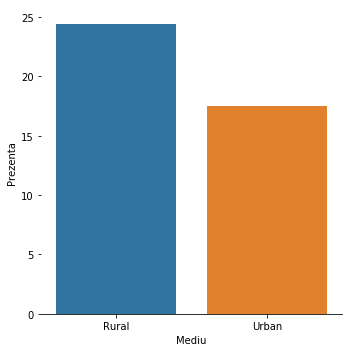

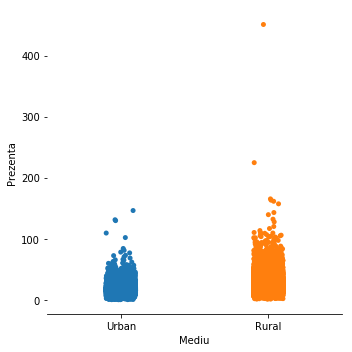

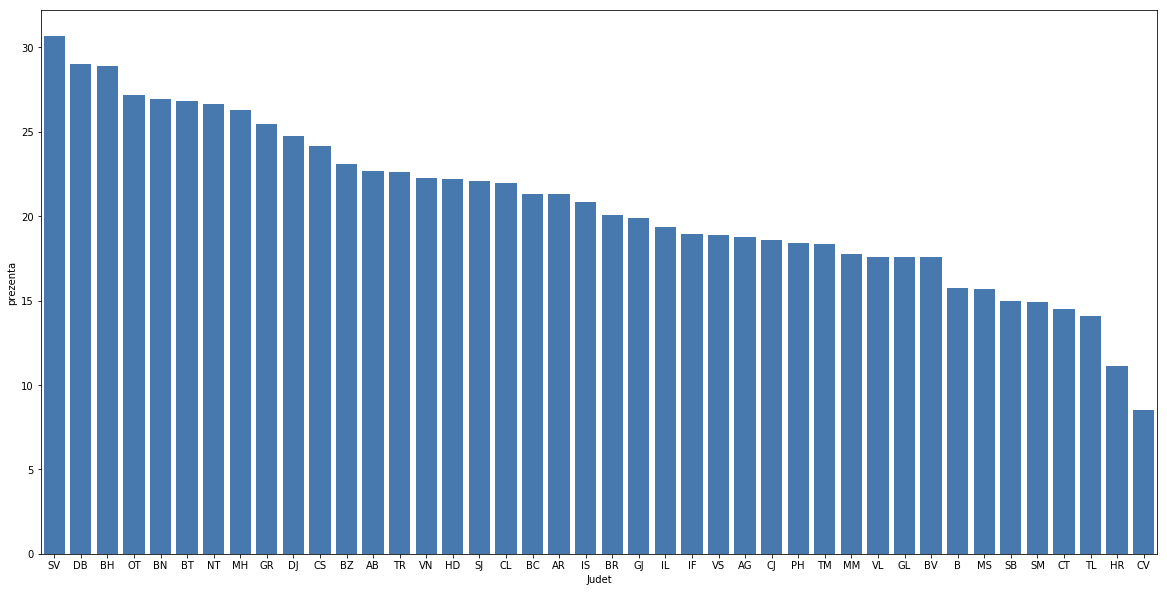

,Judet,Diferenta prezenta
0,MH,20.435729
1,DJ,19.955951
2,CS,14.912916
3,HD,13.131894
4,BH,13.035863


,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,prezenta
51,MH,Rural,33519,7422,836,41777,113551,36.791398
52,MH,Urban,17429,1871,369,19669,120258,16.355669


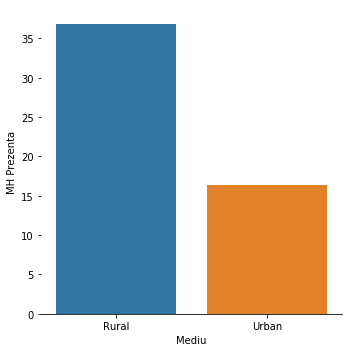

/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


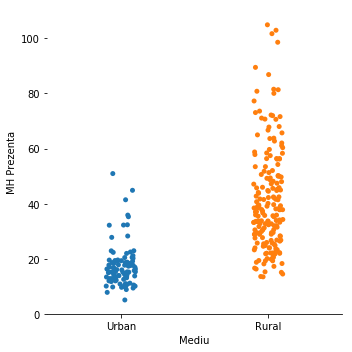

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,prezenta
33,DJ,Rural,76388,13286,1509,91183,253991,35.900091
34,DJ,Urban,44801,4553,1658,51012,319942,15.944140


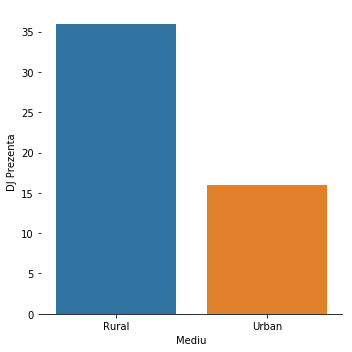

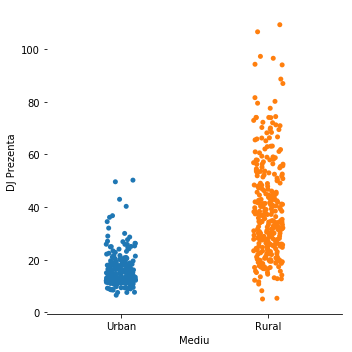

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,prezenta
25,CS,Rural,31918,4314,251,36483,110866,32.907293
26,CS,Urban,25391,2843,121,28355,157577,17.994377


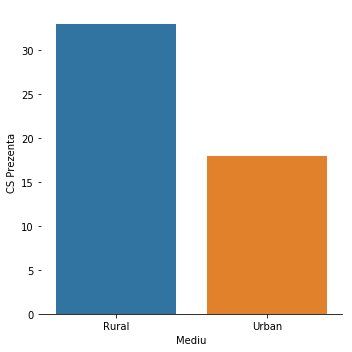

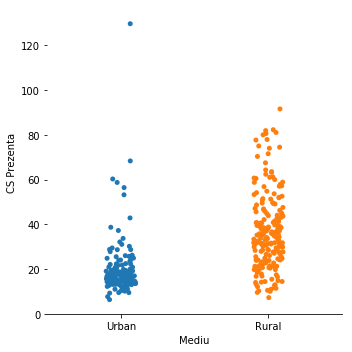

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,prezenta
41,HD,Rural,23665,4271,227,28163,86949,32.390252
42,HD,Urban,53243,3819,985,58047,301412,19.258357


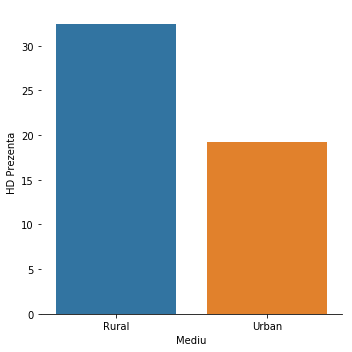

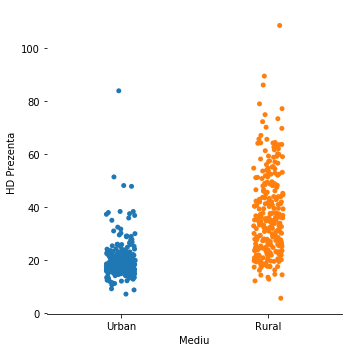

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,prezenta
9,BH,Rural,71868,12175,1320,85363,238565,35.781862
10,BH,Urban,53970,4864,1346,60180,264574,22.745999


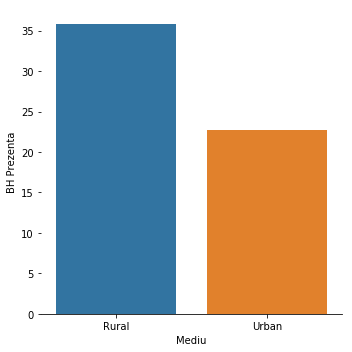

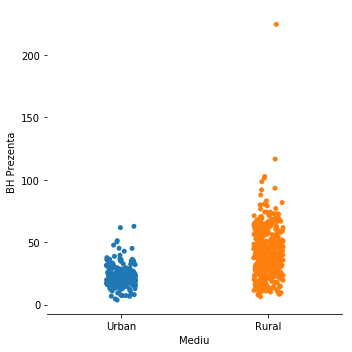

In [36]:
analiza(final_df, "prezenta", "total", "lista", "Prezenta", 5)

## Liste Suplimentare

,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,suplimentare/total
0,Rural,1632726,248817,20345,1901888,7801783,13.082632
1,Urban,1644028,159820,25968,1829816,10476713,8.734212


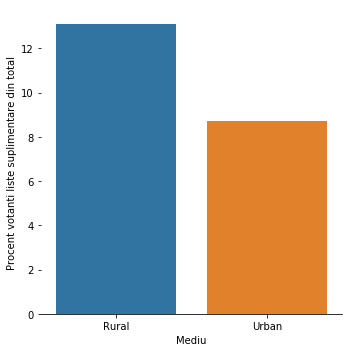

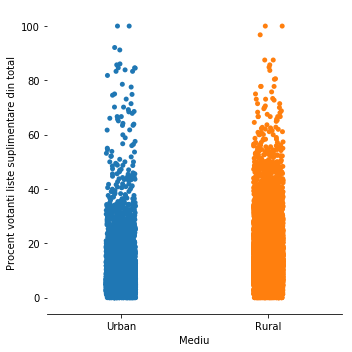

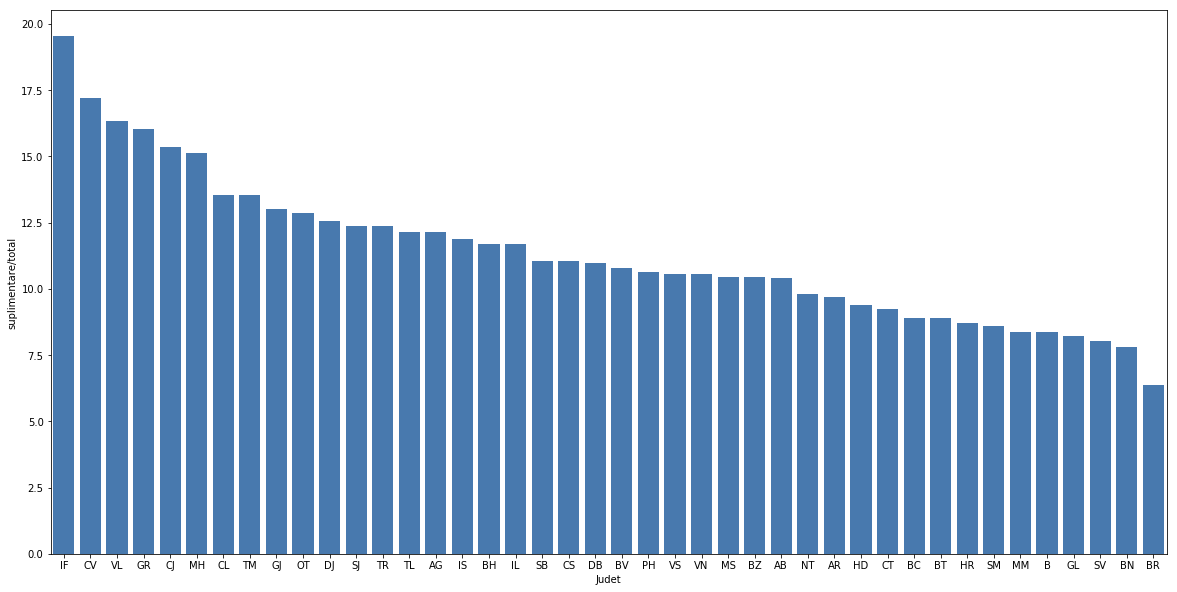

,Judet,Diferenta suplimentare/total
0,SJ,10.146043
1,GR,8.842401
2,HD,8.586136
3,TR,8.277928
4,CL,8.274598


,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,suplimentare/total
65,SJ,Rural,23959,4533,18,28510,110965,15.899684
66,SJ,Urban,14144,873,156,15173,86843,5.753641


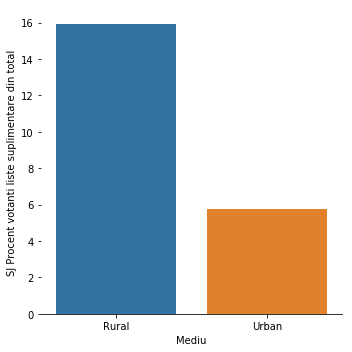

/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


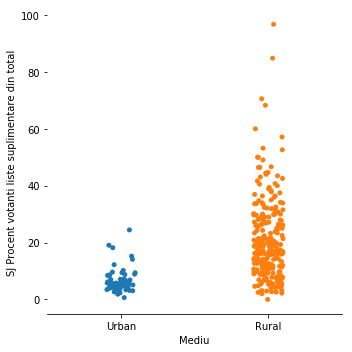

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,suplimentare/total
39,GR,Rural,35863,7988,471,44322,150516,18.022652
40,GR,Urban,11243,1177,401,12821,74140,9.180251


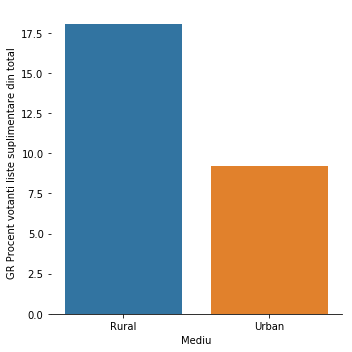

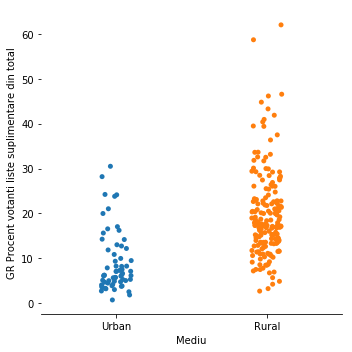

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,suplimentare/total
41,HD,Rural,23665,4271,227,28163,86949,15.165288
42,HD,Urban,53243,3819,985,58047,301412,6.579151


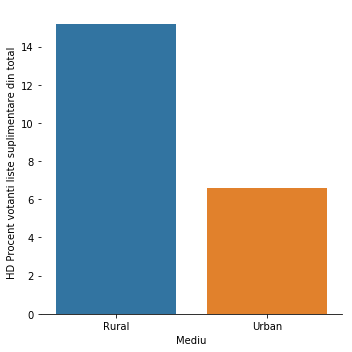

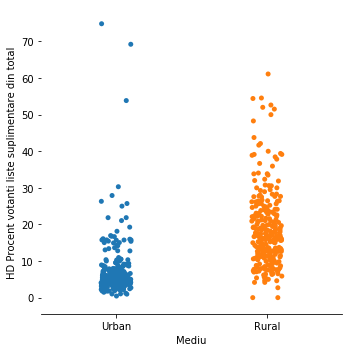

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,suplimentare/total
75,TR,Rural,43414,7662,1698,52774,200699,14.518513
76,TR,Urban,17211,1160,217,18588,114622,6.240585


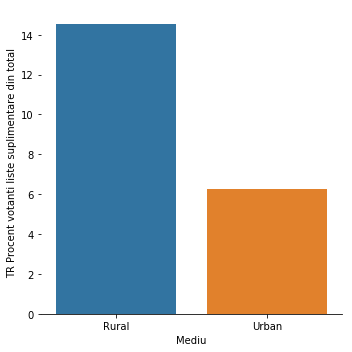

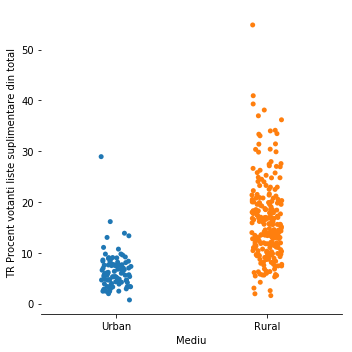

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,suplimentare/total
23,CL,Rural,30542,6050,666,37258,149730,16.238123
24,CL,Urban,16474,1441,180,18095,102190,7.963526


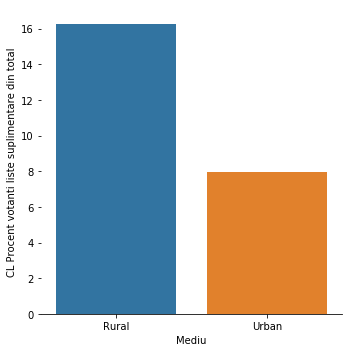

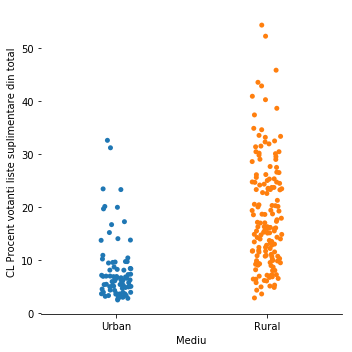

In [37]:
analiza(final_df, "suplimentare/total", "liste_suplimentare", "total", "Procent votanti liste suplimentare din total")

## Urna mobila

,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,urna_mobila/total
0,Rural,1632726,248817,20345,1901888,7801783,1.069727
1,Urban,1644028,159820,25968,1829816,10476713,1.419159


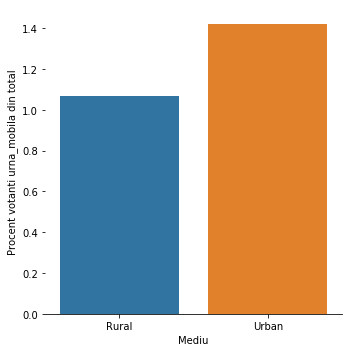

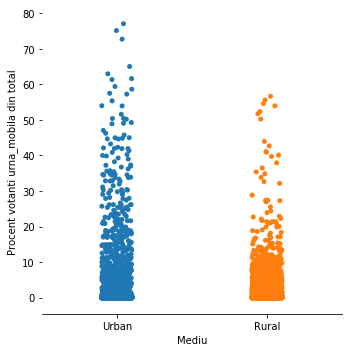

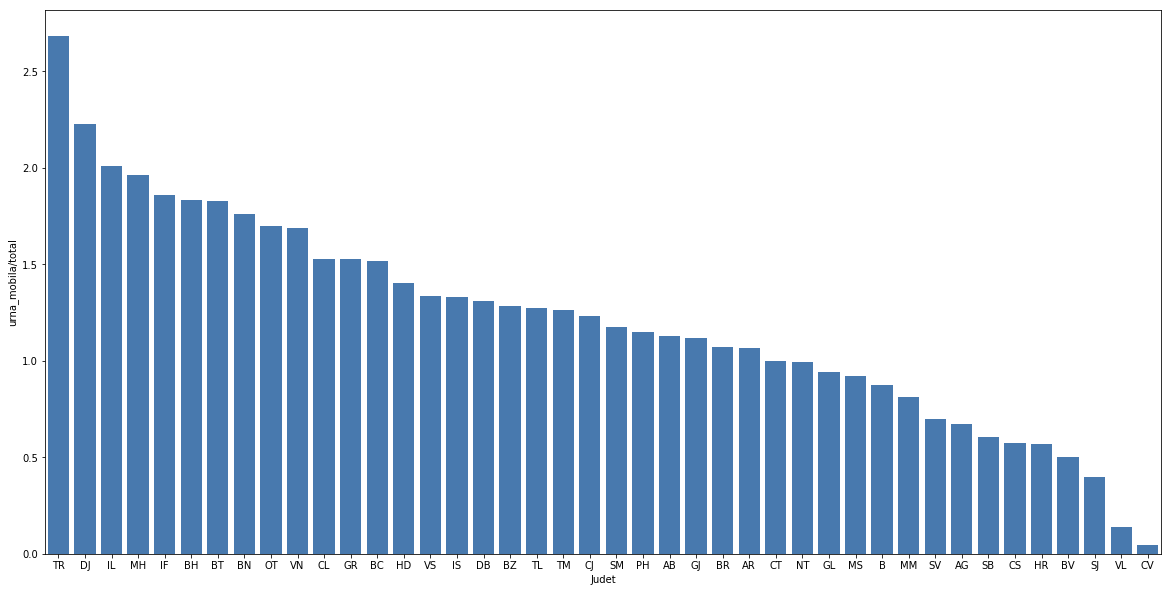

,Judet,Diferenta urna_mobila/total
0,CT,2.799423
1,TR,2.050074
2,IF,1.993179
3,OT,0.975018
4,CL,0.792786


,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,urna_mobila/total
27,CT,Rural,21728,2848,764,25340,185631,3.014996
28,CT,Urban,59729,5537,141,65407,441297,0.215573


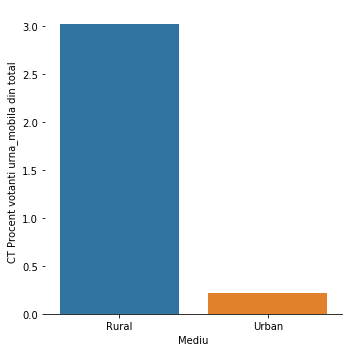

/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


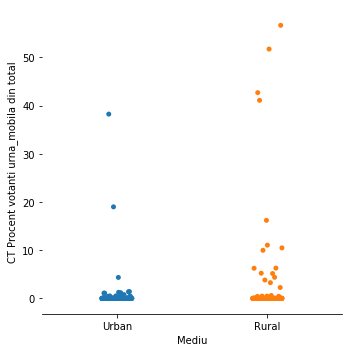

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,urna_mobila/total
75,TR,Rural,43414,7662,1698,52774,200699,3.217493
76,TR,Urban,17211,1160,217,18588,114622,1.167420


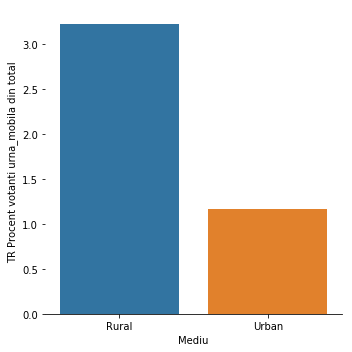

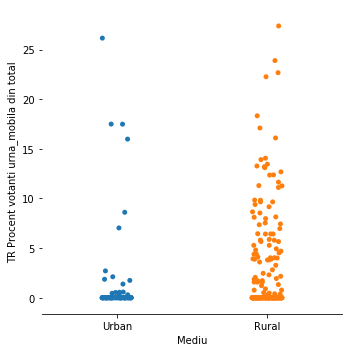

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,urna_mobila/total
45,IF,Rural,28364,8055,1019,37438,190393,2.721833
46,IF,Urban,23612,4862,209,28683,158722,0.728655


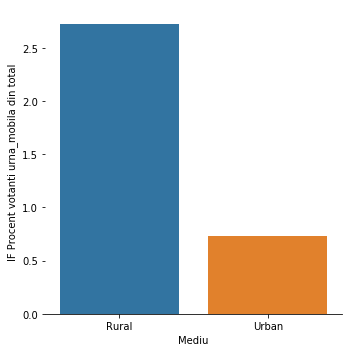

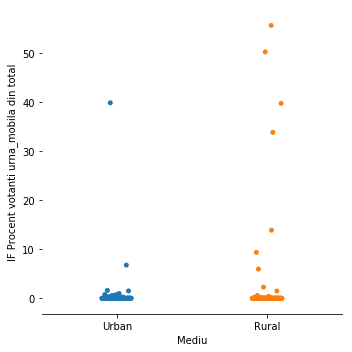

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,urna_mobila/total
59,OT,Rural,56321,10344,1371,68036,209246,2.015110
60,OT,Urban,29501,2563,337,32401,160103,1.040091


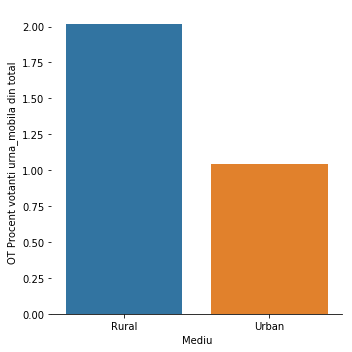

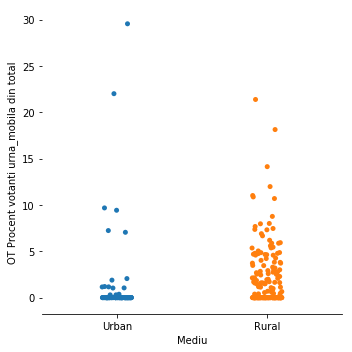

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,urna_mobila/total
23,CL,Rural,30542,6050,666,37258,149730,1.787536
24,CL,Urban,16474,1441,180,18095,102190,0.994750


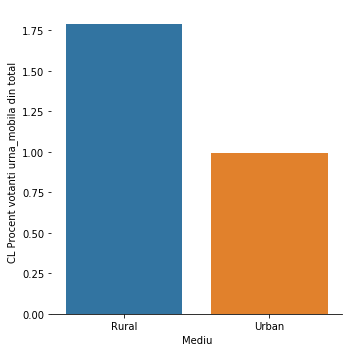

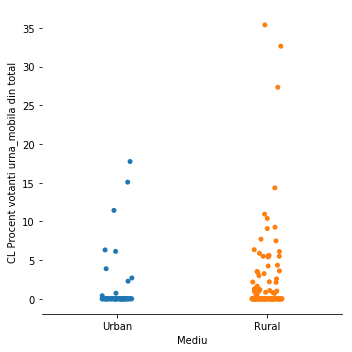

In [38]:
analiza(final_df, "urna_mobila/total", "urna_mobila", "total", "Procent votanti urna_mobila din total")

## Liste suplimentare intervale orare

### 7 Octombrie, 19:00 - 21:00

,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_19:00-21:00
0,Rural,1632726,248817,20345,1901888,7801783,19299,7.756303
1,Urban,1644028,159820,25968,1829816,10476713,15071,9.429984


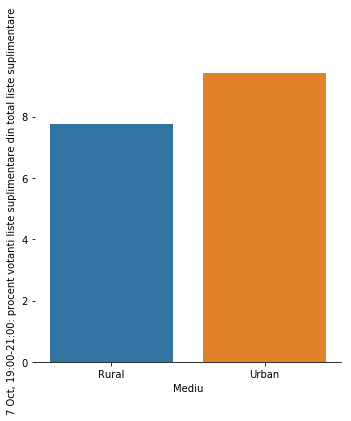

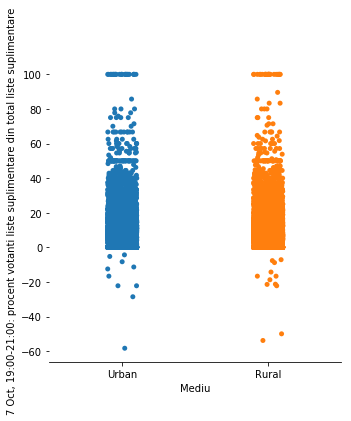

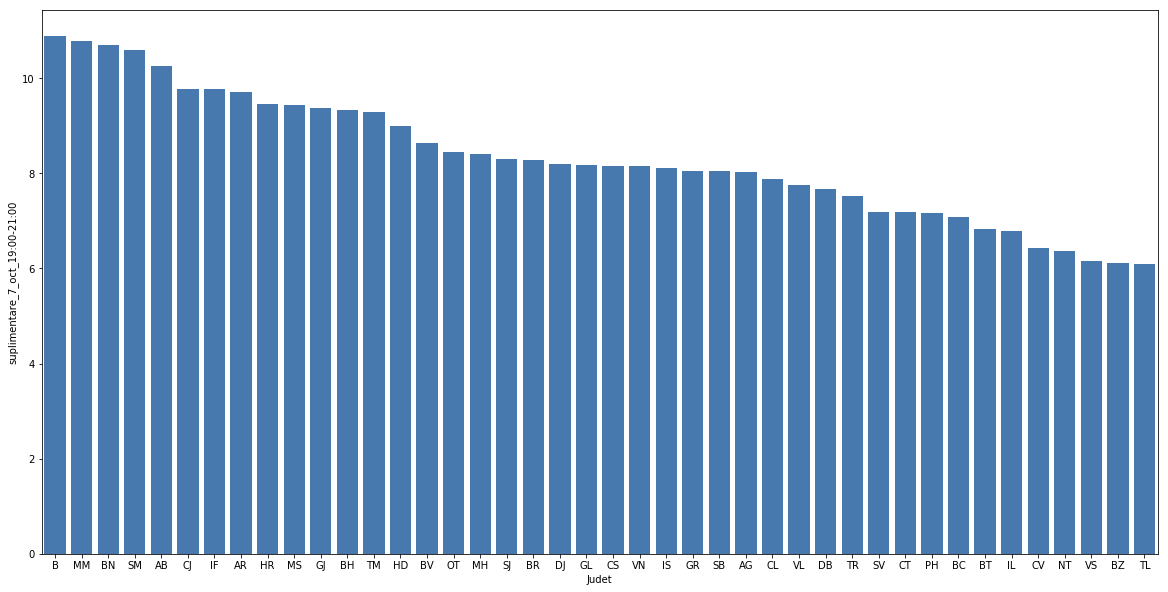

,Judet,Diferenta suplimentare_7_oct_19:00-21:00
0,HR,2.947772
1,CV,2.702055
2,VL,2.465995
3,CS,0.792869
4,MH,0.752332


,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_19:00-21:00
43,HR,Rural,16218,1494,2,17714,148109,160,10.709505
44,HR,Urban,10923,1108,169,12200,120838,86,7.761733


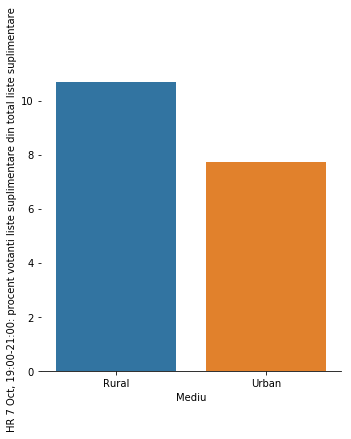

/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


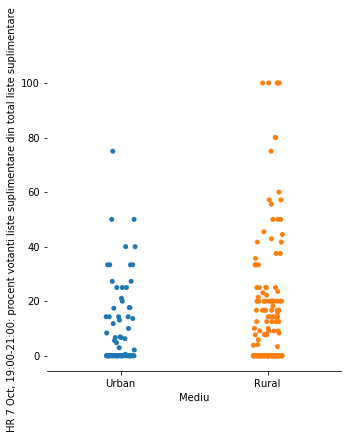

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_19:00-21:00
29,CV,Rural,6102,1097,3,7202,88299,88,8.021878
30,CV,Urban,6760,1579,4,8343,94419,84,5.319823


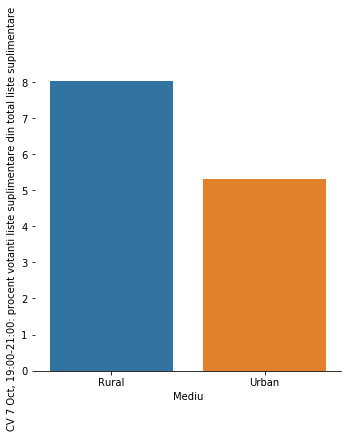

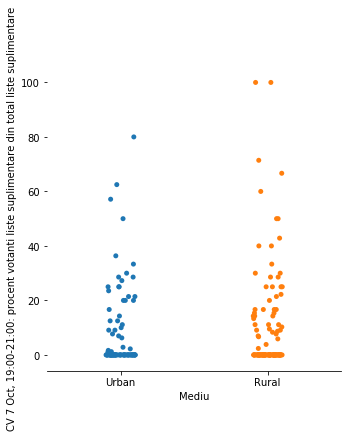

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_19:00-21:00
77,VL,Rural,26097,5456,42,31595,170980,481,8.815982
78,VL,Urban,22616,4063,38,26717,160194,258,6.349988


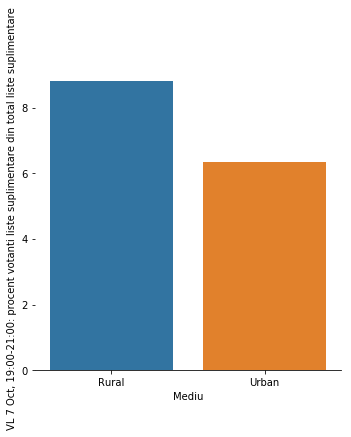

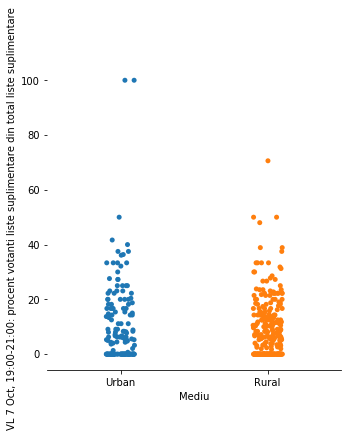

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_19:00-21:00
25,CS,Rural,31918,4314,251,36483,110866,365,8.460825
26,CS,Urban,25391,2843,121,28355,157577,218,7.667956


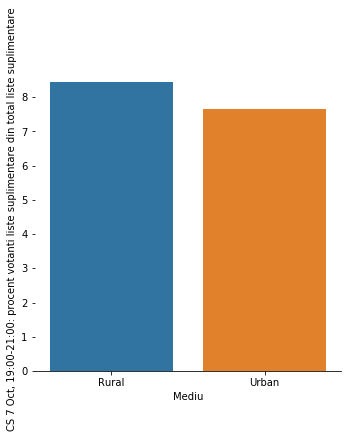

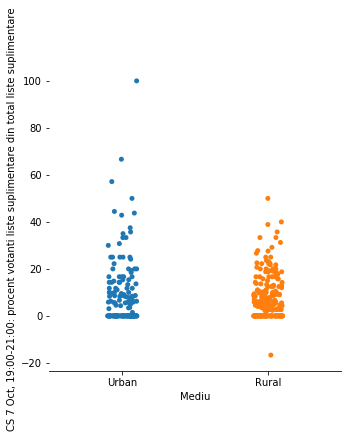

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_19:00-21:00
51,MH,Rural,33519,7422,836,41777,113551,635,8.555645
52,MH,Urban,17429,1871,369,19669,120258,146,7.803314


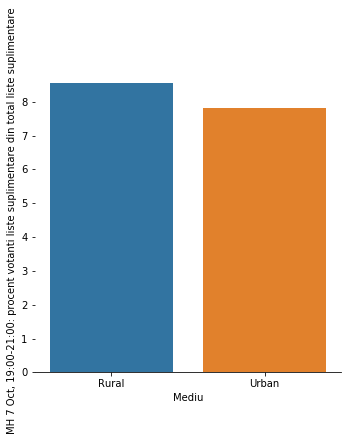

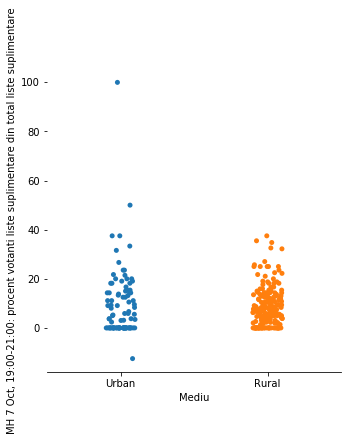

In [39]:
analiza(final_df, "suplimentare_7_oct_19:00-21:00", "liste_suplimentare_interval_precedent", "liste_suplimentare", "7 Oct, 19:00-21:00: procent votanti liste suplimentare din total liste suplimentare")

### 7 Octombrie, 16:00 - 19:00

,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_16:00-19:00
0,Rural,1495467,229518,19646,1744631,7801783,44429,19.357523
1,Urban,1535404,144749,25405,1705558,10476713,24750,17.098564


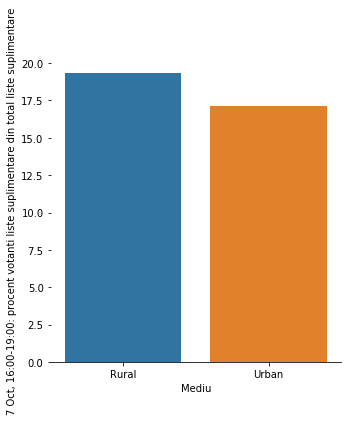

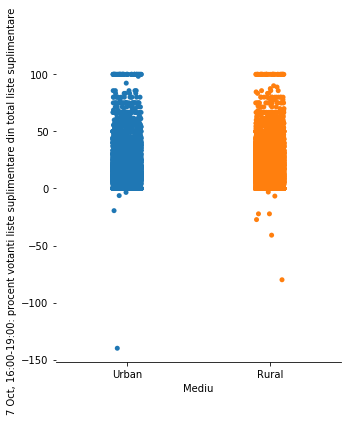

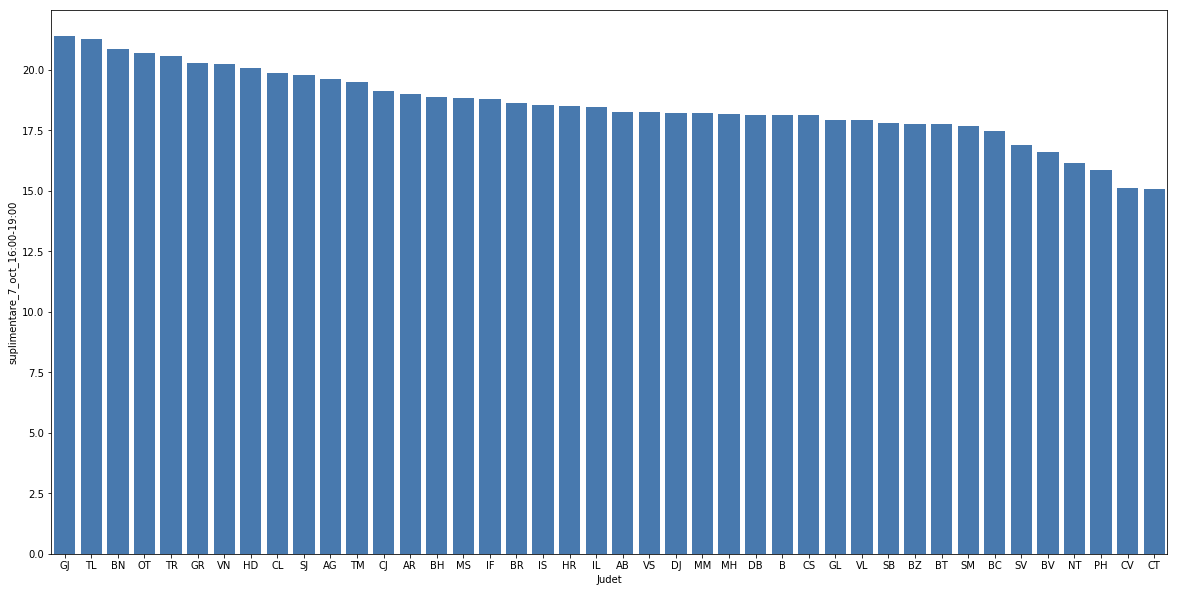

,Judet,Diferenta suplimentare_7_oct_16:00-19:00
0,GR,8.520294
1,VL,8.447335
2,CS,7.988520
3,TR,6.583216
4,GJ,6.260519


,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_16:00-19:00
39,GR,Rural,31331,7359,468,39158,150516,1571,21.348009
40,GR,Urban,10417,1068,400,11885,74140,137,12.827715


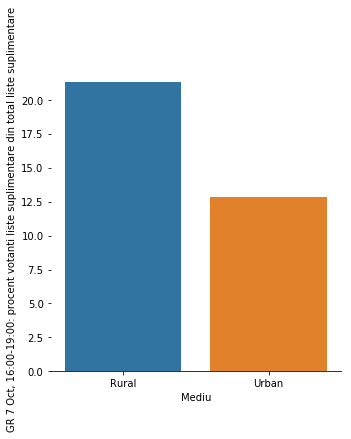

/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mihaias/.virtualenvs/data/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


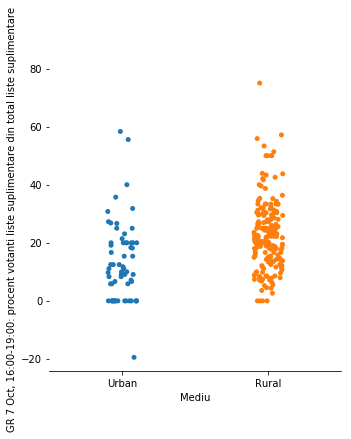

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_16:00-19:00
77,VL,Rural,23115,4975,42,28132,170980,1074,21.587940
78,VL,Urban,20811,3805,38,24654,160194,500,13.140604


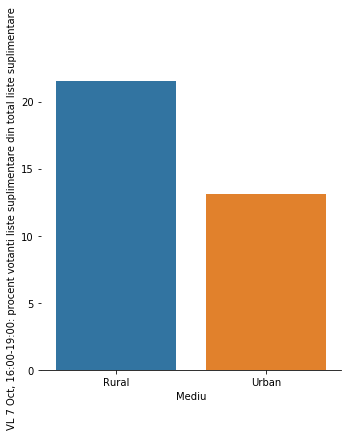

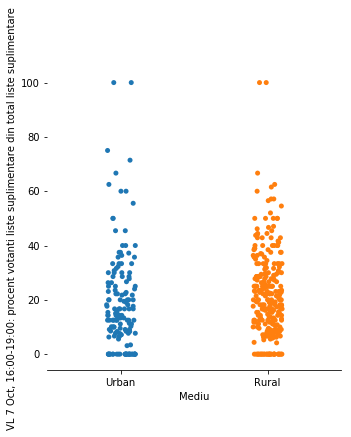

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_16:00-19:00
25,CS,Rural,28910,3949,232,33091,110866,842,21.321854
26,CS,Urban,23775,2625,121,26521,157577,350,13.333333


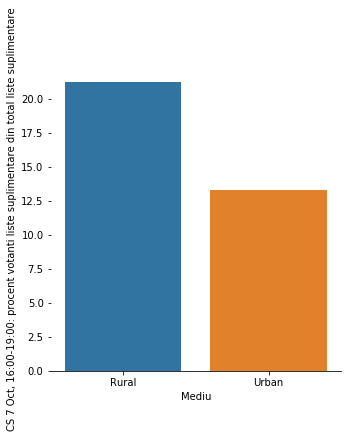

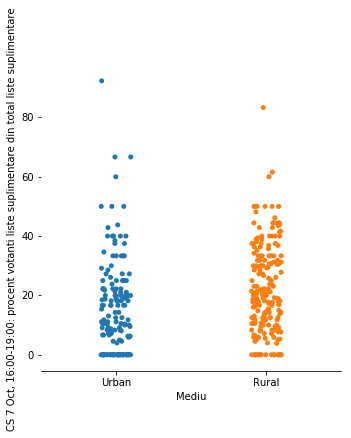

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_16:00-19:00
75,TR,Rural,38466,7100,1621,47187,200699,1521,21.422535
76,TR,Urban,15870,1058,217,17145,114622,157,14.839319


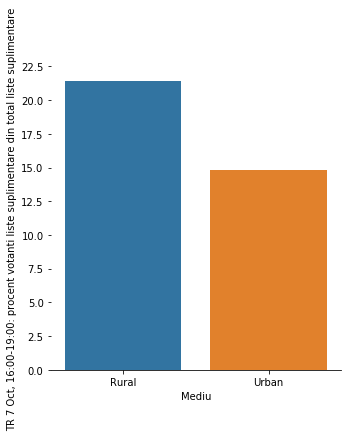

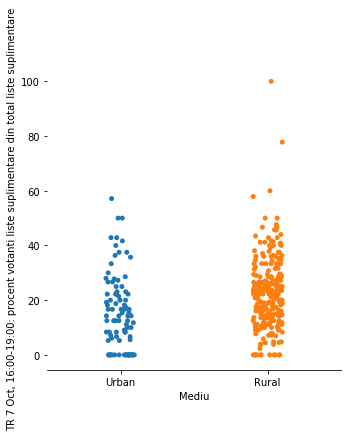

,Judet,Mediu,liste_permanente,liste_suplimentare,urna_mobila,total,lista,liste_suplimentare_interval_precedent,suplimentare_7_oct_16:00-19:00
35,GJ,Rural,27535,5354,187,33076,154445,1227,22.917445
36,GJ,Urban,18651,1711,481,20843,146104,285,16.656926


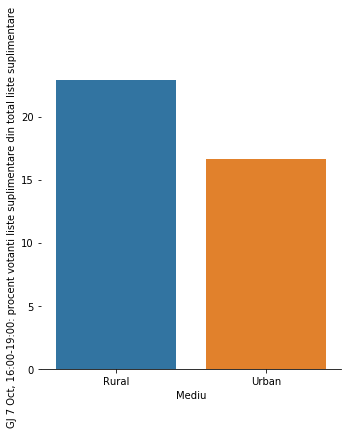

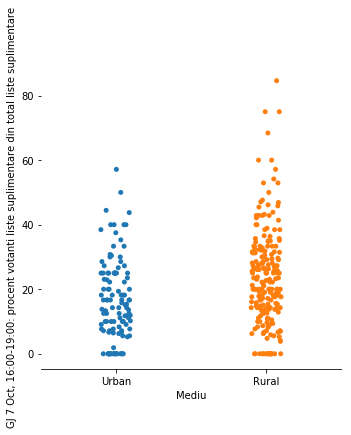

In [40]:
final_df = total_presence_df[total_presence_df["time"] == "2018-10-07_19-00"]
analiza(final_df, "suplimentare_7_oct_16:00-19:00", "liste_suplimentare_interval_precedent", "liste_suplimentare", "7 Oct, 16:00-19:00: procent votanti liste suplimentare din total liste suplimentare")

### Date pe sectii de votare

,val,liste_permanente,liste_suplimentare
38454,"BH, sectie:551",133,839
52744,"BV, sectie:312",159,310
68324,"CS, sectie:104",267,613
77264,"CV, sectie:77",69,413
111534,"IS, sectie:30",149,970
136314,"NT, sectie:482",121,625
157734,"SV, sectie:117",216,407
174644,"VL, sectie:115",324,736
174894,"VL, sectie:141",109,605


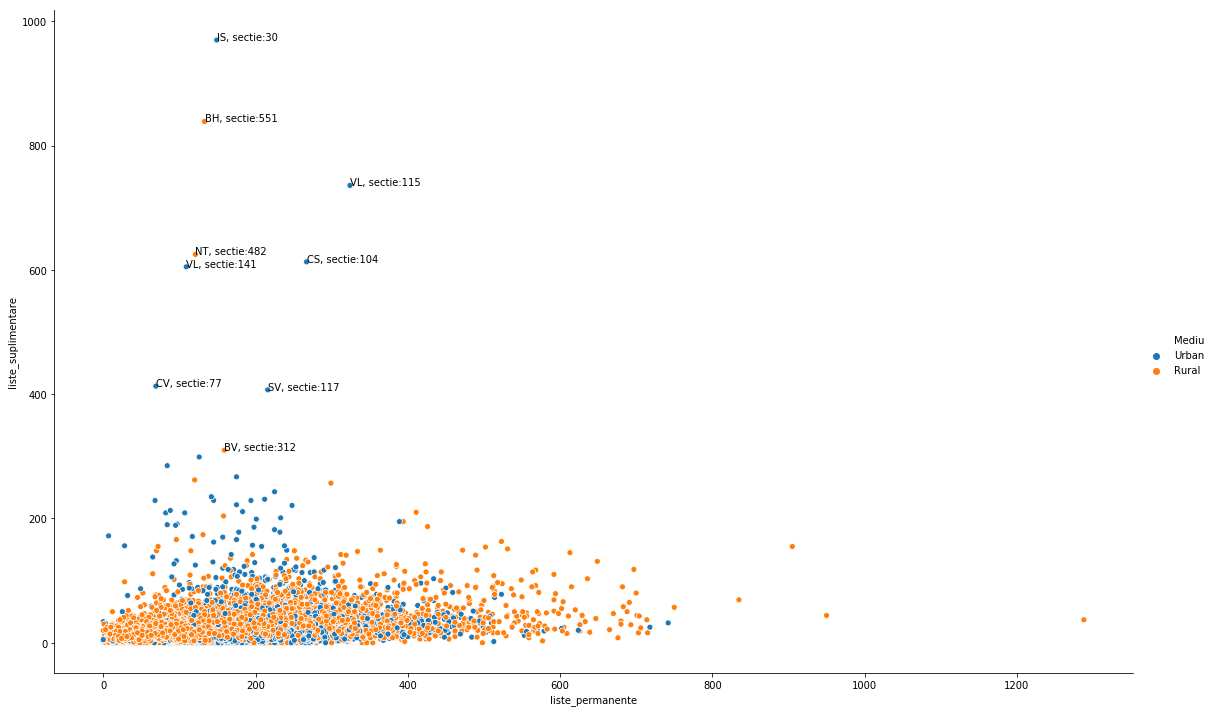

,val,liste_permanente,liste_suplimentare
38464,"BH, sectie:552",531,151
56874,"BZ, sectie:276",131,174
58384,"CJ, sectie:1",7,172
58404,"CJ, sectie:3",196,157
73854,"CT, sectie:292",117,171
73874,"CT, sectie:294",175,166
83544,"DJ, sectie:59",178,178
84364,"DJ, sectie:141",238,156
85664,"DJ, sectie:271",426,187
85874,"DJ, sectie:292",502,154


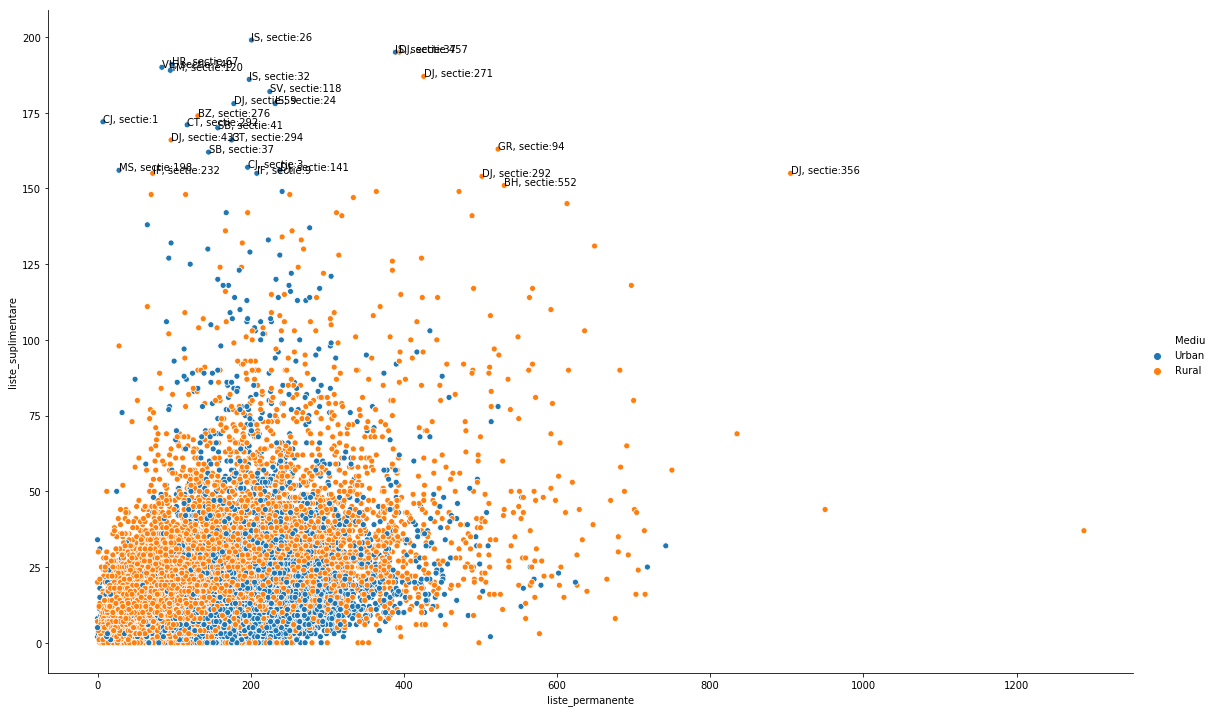

In [41]:
data_df = final_df

def plot_scatter_permanente_suplimentare(data_df, min_liste_suplimentare):
    def label_point(x, y, val, ax, min_liste_suplimentare):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a[a.y > min_liste_suplimentare].iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))
        a = a[a.y > min_liste_suplimentare]
        a.rename(columns={"x": x.name, "y": y.name}, inplace=True)
        display(a)
        
    sns.relplot(x="liste_permanente", y="liste_suplimentare", hue="Mediu",
                data=data_df, height=10, aspect=16/10)
    label_point(data_df["liste_permanente"], data_df["liste_suplimentare"],
                data_df.Judet + ", sectie:" + data_df["Nr Sectie"].astype(str), plt.gca(), min_liste_suplimentare)
    plt.show()
plot_scatter_permanente_suplimentare(final_df, 300)
data_df = final_df[final_df["liste_suplimentare"] < 200]
plot_scatter_permanente_suplimentare(data_df, 150)